# Final SEED Code

### Created by Michael Vause, 31/03/2020
#### tkinter doesn't work on macos 10.14.6 

SEED Loading
3000
Python version 3.7.6 installed
Matlab engine installed
Exiting SEED


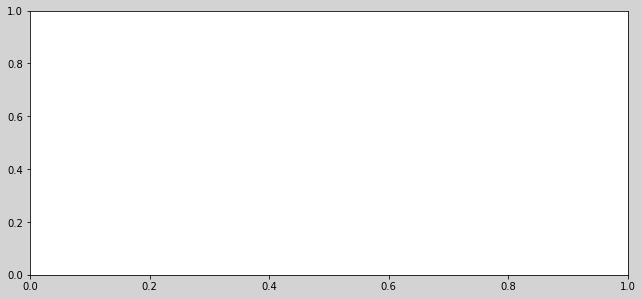

In [1]:
# Check Python version 3.6 or 3.7 is installed, exit SEED if not

print("SEED Loading")
import sys
sys.setrecursionlimit(3000) # To allow fourth pySINDy example to work
py_ver = sys.version.split(" ", 1)[0] # Get Python version
to_print = "Python version " + py_ver + " installed"
print(to_print)
if not (py_ver.startswith("3.6") or py_ver.startswith("3.7")): # Exit seed if Python 3.6 or 3.7 not in use
    print("Python version 3.6 or 3.7 required")
    print("Exiting SEED")
    sys.exit()


# Import all required modules

try:
    import tkinter as tk
    from tkinter import ttk
    from tkinter import messagebox
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
    import os
    import importlib
except ImportError:
    print("Install the required modules before starting. Run: \"python -m pip install --user numpy scipy matplotlib pysindy findiff pytest pylint sphinx\" in your command line.")
    sys.exit()
except Exception as inst:
    print("Error while importing: " + str(inst))
    sys.exit()
    
# Check for the Matlab engine for Python, start it if installed
try:
    import matlab.engine
    print("Matlab engine installed")
    eng = matlab.engine.start_matlab()
except ImportError:
    print("Matlab engine not installed")


# Any functions used throughout SEED

# Take a file path and return all the non hidden files
def non_hidden(path):
    files = []
    for file in os.listdir(path):
        if not file.startswith("."):
            files.append(file)
    return files

# Refresh examples drop down menu
def refresh_ex(command):
    new_options = []
    select_menu.children["menu"].delete(0, "end")
    old_options = non_hidden("Algorithms/"+str(alg_var.get())+"/examples")
    old_options.sort()
    old_options.append("Own Data")
    old_clone = old_options.copy()
    for example in old_clone:
        if example == "__pycache__":
            old_options.remove("__pycache__")
        elif example == "data":
            old_options.remove("data")
        elif example == "utils":
            old_options.remove("utils")
        elif example.startswith("Own_Data"):
            old_options.remove(example)
    
    for op in old_options:
        new_options.append(op)
        select_menu.children["menu"].add_command(label=op,command= lambda o=op:new_com(o))
    sel_var.set(new_options[0])
    refresh_data("<command>")

# New command for examples select menu
def new_com(name):
    sel_var.set(name)
    refresh_data("<command>")
    
# Refresh data drop down menu when "Own Data" option selected in examples
def refresh_data(command):
    new_systems = []
    data_menu.children["menu"].delete(0, "end")
    if str(sel_var.get()) == "Own Data":
        old_systems = non_hidden("Data")
        old_systems.sort()
        for sys in old_systems:
            new_systems.append(sys)
            data_menu.children["menu"].add_command(label=sys,command= lambda s=sys:data_var.set(s))
        data_var.set(new_systems[0])
    else:
        data_var.set(" ")
        
    update_param_fram()
        
# Compute button to run selected example
def comp():
    selection = str(sel_var.get())
    if selection == "Own Data": # Compute coeffiecients for users own data
        path = "Algorithms/"+str(alg_var.get())+"/examples"
        examples = non_hidden(path)
        for value in examples:
            if value.startswith("Own_Data"):
                eg = value
        
        if eg.endswith(".m"):    
            input_data = str(data_var.get())
            to_import = eg.split(".m", 1)[0]
            to_import = to_import + "(\""+ input_data + "\");"
        
            try:
                eng.addpath(path)
                [coefout,desc] = eng.eval(str(to_import),nargout=2)
                update_matlab(coefout,desc)
            except NameError:
                messagebox.showwarning(title="Error", message="Example not run. Matlab engine not installed.")
            except Exception as inst:
                mssg = "Error in comp function 1: " + str(inst)
                messagebox.showerror(title="Error", message=mssg)
                
        elif eg.endswith(".py"):
            try:
                to_import = eg.split(".py", 1)[0]
                to_run = importlib.import_module(to_import)
                input_data = str(data_var.get())
            
                [coef,desc] = to_run.example(input_data)
                update_out(coef,desc)
            except Exception as inst:
                mssg = "Error in comp function 2: " + str(inst)
                messagebox.showerror(title="Error", message=mssg)
        else:
            messagebox.showerror(title="Error", message="Unable to compute own data")
            
    elif selection.endswith(".py"): # Compute output for selected Python example
        try:
            to_import = selection.split(".py", 1)[0]
            to_run = importlib.import_module(to_import)
    
            [coef,desc] = to_run.example()
            update_out(coef,desc)
        except FileNotFoundError:
            messagebox.showwarning(title="Error", message="The data has not been generated for this example yet. Read the README.md file for generation instructions.")
        except RecursionError:
            messagebox.showerror(title="Error", message="Recursion limit too small")
        except Exception as inst:
            mssg = "Error in comp function 3: " + str(inst)
            messagebox.showerror(title="Error", message=mssg)
        
    elif selection.endswith(".m"): # Compute output for selected Matlab example
        to_import = selection.split(".m", 1)[0]
        to_import = to_import + "();"
        to_add = "Algorithms/"+str(alg_var.get())+"/examples"
        
        try:
            eng.addpath(to_add)
            [coefout,desc] = eng.eval(str(to_import),nargout=2)
            update_matlab(coefout,desc)
        except NameError:
            messagebox.showwarning(title="Error", message="Example not run. Matlab engine not installed.")
        except Exception as inst:
            mssg = "Error in comp function 4: " + str(inst)
            messagebox.showerror(title="Error", message=mssg)
    
# Update output list box and plot
def update_out(coef,desc):
    tv.delete(*tv.get_children())
    
    for item in range(len(desc)):
        new_val = []
        for col in range(len(coef[0])):
            new_val.append(str(coef[item,col]))
        tv.insert('', 'end', text=desc[item], values=new_val)
    
    plot(coef,desc)

# Update the output for the inbuilt matlab examples
def update_matlab(coefout,desc):    
    coeflist = [ item for elem in coefout for item in elem]
    num_rows = int(len(coeflist)/len(coefout[0]))
    num_cols = int(len(coefout[0]))
    
    for x in range(0,num_rows):
        row = np.array([coeflist[num_cols*x]])
        for y in range(1,num_cols):
            value = coeflist[(num_cols*x)+y]
            row = np.append(row,[value])
        
        row = [row]
        if (x==0):
            coef = np.array(row)
        else:
            coef = np.append(coef, row, axis = 0)

    update_out(coef,desc)

# Display parameters used in each example
def update_param_fram():
    module_path = os.path.abspath(os.path.join('.'))
    module_path = module_path + "/Algorithms/"+str(alg_var.get())+"/examples"
    if module_path not in sys.path:
        sys.path.append(module_path)

    count = 0
    variables = []
    values = []

    # Delete contents currently in parameter frame
    for child in param_fram.winfo_children():
        if count > 0:
            child.destroy()
        count = count + 1
    
    eg = str(sel_var.get())
    
    if eg == "Own Data": #Own data parameters, there are none as system not know
        pass
    elif eg.endswith(".py"): #Python example parameters
        to_import = eg.split(".py", 1)[0]
        to_run = importlib.import_module(to_import)
        [variables,values] = to_run.get_params()
    elif eg.endswith(".m"): #Matlab example parameters
        to_import = eg.split(".m", 1)[0]
        to_import = to_import + "(1);"
        to_add = "Algorithms/"+str(alg_var.get())+"/examples"

        try:
            eng.addpath(to_add)
            [variables,values] = eng.eval(str(to_import),nargout=2)
        except NameError:
            print("Matlab engine not installed")
        
    # Display all variables
    height = len(variables)
    for i in range(height):
        var_text = variables[i]
        var_box = tk.Label(param_fram, text=var_text, font=("Times",15), bg=bgc)
        var_box.grid(row=(i+1), column=1)
        
        val_text = values[i]
        val_box = tk.Label(param_fram, text=val_text, font=("Times",15), bg=bgc)
        val_box.grid(row=(i+1), column=2)

# Plotting function for SEED's figure
def plot(coef,desc):
    plt.clf()
    rows = len(coef)
    dims = len(coef[0])

    for dim in range(dims):
        coef_plt = []
        desc_plt = []
        for num in range(rows):
            row = coef[num]
            val = row[dim]
            des = desc[num]
            if val != 0:
                coef_plt.append(val)
                desc_plt.append(des)
        if 2*len(coef_plt) > 10:
            size = 8
        else:
            size = 10
        matplotlib.rc('xtick', labelsize=size)  
        plt.subplot(dims,1,(dim+1))
        plt.bar(desc_plt,coef_plt)
        plt.axhline(y=0, color='k')

    # Update plot
    plt.gcf().canvas.draw()

# Function to run on closing the window
def on_closing():    
    if messagebox.askokcancel("Quit", "Do you want to quit?"):
        # Quit the Matlab engine if open
        try:
            eng.quit()
        except NameError:
            pass
        
        print("Exiting SEED")    
        window.destroy()


# GUI design

# Background colour
bgc = "lightgray"

# GUI window
window = tk.Tk()
window.title("Extracting Equations from Data")
window.minsize(1000,500)
window.maxsize(1200,670)
window.config(bg=bgc)
#window.resizable(False, False)  #This is optional

# Add all algorithm paths to software
alg_options = non_hidden("Algorithms")
alg_options.sort()
to_add = alg_options

if "Own Data" in to_add:
    to_add.remove("Own Data")

for alg in to_add:
    module_path = os.path.abspath(os.path.join('.'))
    module_path = module_path + "/Algorithms/"+str(alg)
    if module_path not in sys.path:
        sys.path.append(module_path)

# Add all the dropdown Labels
main_label = tk.Label(window,text="Extracting Equations from Data",font=("Times",35,"bold","underline"),padx=5,pady=10,bg=bgc)
main_label.grid(row=0,column=0,rowspan=2,columnspan=4)

algorithm_label = tk.Label(window,text="Algorithm Select:",font=("Times",15,"bold"),pady=10,bg=bgc)
algorithm_label.grid(row=2,column=0,sticky="E")

select_label = tk.Label(window,text="Example/Own Data:",font=("Times",15,"bold"),pady=10,bg=bgc)
select_label.grid(row=3,column=0,sticky="E")

data_label = tk.Label(window,text="Input Data:",font=("Times",15,"bold"),pady=10,bg=bgc)
data_label.grid(row=4,column=0,sticky="E")

# Creating dropdowns & variables
alg_var = tk.StringVar(window)
alg_var.set(alg_options[0])

algorithm_menu = tk.OptionMenu(window,alg_var,*alg_options,command=refresh_ex)
algorithm_menu.config(width=30,font=("Times",15),bg=bgc)
algorithm_menu.grid(row=2,column=1,columnspan=3,sticky="nsew")
     
sel_var = tk.StringVar(window)
sel_options = non_hidden("Algorithms/"+str(alg_var.get())+"/examples")
if "__pycache__" in sel_options:
    sel_options.remove("__pycache__")
for example in sel_options:
    if example.startswith("Own_Data"):
        sel_options.remove(example)
sel_options.sort()
sel_options.append("Own Data")
sel_var.set(sel_options[0])

select_menu = tk.OptionMenu(window,sel_var,*sel_options,command=refresh_data)
select_menu.config(width=30,font=("Times",15),bg=bgc)
select_menu.grid(row=3,column=1,columnspan=3,sticky="nsew")

data_var = tk.StringVar(window)
data_options = [" "]
data_var.set(" ")

data_menu = tk.OptionMenu(window,data_var,*data_options)
data_menu.config(width=30,font=("Times",15),bg=bgc)
data_menu.grid(row=4,column=1,columnspan=3,sticky="nsew")

# Add frame for parameter display
param_fram = tk.Frame(window,bg=bgc,bd=2,relief="sunken",pady=10)

param_label = tk.Label(param_fram,text="Parameters",font=("Times",15,"bold"),bg=bgc,width=62)
param_label.grid(row=0,column=0,columnspan=4,sticky="nsew")

param_fram.grid(row=5,column=0,rowspan=2,columnspan=4,padx=5,pady=10,sticky="NW")

refresh_data("<command>")

# Add frame for compute button
button_fram = tk.Frame(window,bg=bgc,bd=2,relief="sunken",pady=10)

blank_line1 = tk.Label(button_fram,text=" ",font=("Times",15),width=61,highlightbackground=bgc,bg=bgc)
blank_line1.grid(row=0,column=0,columnspan=4)

comp_button = tk.Button(button_fram,text="Compute",command=comp,font=("Times",15,"bold"),width=20,highlightbackground=bgc)
comp_button.grid(row=1,column=1,columnspan=2,sticky="EW")

blank_line2 = tk.Label(button_fram,text=" ",font=("Times",15),width=61,highlightbackground=bgc,bg=bgc)
blank_line2.grid(row=2,column=0,columnspan=4)

button_fram.grid(row=7,column=0,rowspan=3,columnspan=4,padx=5,sticky="SEW")

# Add frame for output values title & scroll box
fig1_fram = tk.Frame(window,bd=2,bg=bgc)

fig1_label = tk.Label(fig1_fram,text="Coefficient Values",font=("Times",18,"bold"),pady=10,bg=bgc)
fig1_label.grid(row=0,column=0,sticky="W")

output_scroll = tk.Scrollbar(fig1_fram)
output_scroll.grid(row=1,column=1,rowspan=4,sticky="nsew")

tv = ttk.Treeview(fig1_fram, yscrollcommand = output_scroll.set)
tv['columns'] = ('col1', 'col2', 'col3')
col_width = 160
tv.heading("#0", text='Descriptor', anchor='w')
tv.column("#0", anchor="w", width=col_width, stretch=False)
tv.heading('col1', text='Equation One')
tv.column('col1', anchor='center', width=col_width, stretch=False)
tv.heading('col2', text='Equation Two')
tv.column('col2', anchor='center', width=col_width, stretch=False)
tv.heading('col3', text='Equation Three')
tv.column('col3', anchor='center', width=col_width, stretch=False)
tv.grid(row=1,column=0)

output_scroll.config(command = tv.yview)

fig1_fram.grid(row=0,column=4,rowspan=5,padx=5,sticky="W")

# Add frame for output graph title & plot
fig2_fram = tk.Frame(window,bd=2,bg=bgc)

fig2_label = tk.Label(fig2_fram,text="Coefficient Plot",font=("Times",18,"bold"),pady=10,bg=bgc)
fig2_label.grid(row=0,column=0,sticky="NW")

fig2 = plt.figure()
fig2.add_subplot(111)
fig2.patch.set_facecolor(bgc)
fig2.subplots_adjust(left=0.07,hspace=0.4)
canvas = FigureCanvasTkAgg(fig2, fig2_fram)
canvas.get_tk_widget().grid(row=1,column=0,sticky="NW")
canvas.get_tk_widget().configure(background=bgc,width=(720),height=(350))

fig2_fram.grid(row=6,column=4,rowspan=3,padx=5,sticky="NW")

# Enter mainloop
window.protocol("WM_DELETE_WINDOW", on_closing)
window.mainloop()